In [1]:
from utils_v1 import *
# root_path = 'F:/Doctorado/Deforestation_SAR/Tensorflow2/INPE_Project/'
root_path = 'D:/jorg/phd/fifth_semester/project_forestcare/data/'

In [2]:
# Loading images
image_stack = np.load(root_path+'filt_norm_img_2019_2020.npy')

# Loading reference
label_mask = np.load(root_path+'label_mask_2019_2020.npy')

print('image shape: ', '\n', image_stack.shape, '\n', 'reference shape: ', '\n', label_mask.shape)

# Print pertengate of each class (whole image)
no_def = len(label_mask[label_mask==0])
def_ = len(label_mask[label_mask==1])
pt_def = len(label_mask[label_mask==2])
print('Percentage of deforestaion class is {:.2f}'.format((def_*100)/(label_mask.shape[0]*label_mask.shape[1])))
print('Percentage of no-deforestaion class is {:.2f}'.format((no_def*100)/(label_mask.shape[0]*label_mask.shape[1])))
print('Percentage of past-deforestaion class is {:.2f}'.format((pt_def*100)/(label_mask.shape[0]*label_mask.shape[1])))

image shape:  
 (5013, 5003, 14) 
 reference shape:  
 (5013, 5003)
Percentage of deforestaion class is 0.15
Percentage of no-deforestaion class is 76.99
Percentage of past-deforestaion class is 22.85


In [3]:
# Creating tile mask
grid_x, grid_y = 5,5
mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], grid_size=(grid_x, grid_y))
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)

Tiles size:  1002 1000
Mask size:  (5010, 5000)
mask:  (5010, 5000)
image stack:  (5010, 5000, 14)
ref : (5010, 5000)


In [4]:
# Defining tiles for training, validation and test sets
tiles_tr = [2,4,5,6,7,12,14,15,18,21,23,24] 
tiles_val = [9,11,25]
tiles_ts = list(set(np.arange(grid_x * grid_y)+1)-set(tiles_tr)-set(tiles_val))
    
print('Training tiles: ', tiles_tr)
print('Validation tiles: ', tiles_val)
print('Test tiles: ', tiles_ts)

# Training and validation mask
mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')

for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [5]:
overlap = 0.75
patch_size = 128
batch_size = 32
im_idx = create_idx_image(label_mask)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [6]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))

Number of training and validation patches:   9787 2268


In [7]:
# Keeping patches with 2% of def class
X_train = retrieve_idx_percentage(label_mask, patches_idx_trn, patch_size, pertentage = 0.2)
X_valid = retrieve_idx_percentage(label_mask, patches_idx_val, patch_size, pertentage = 0.2)
print('training samples: ', X_train.shape, 'validation samples: ', X_valid.shape)

training samples:  (924, 128, 128) validation samples:  (275, 128, 128)


In [8]:
# Creating train and validation data generator
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_stack, label_mask, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_stack, label_mask, patch_size, number_class)

In [9]:
exp = 0
path_exp = root_path+'Experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [10]:
metrics_all = []

for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    channels = image_stack.shape[-1]
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    
    loss = weighted_categorical_crossentropy(weights)
    input_shape = (rows, cols, channels)
    model = build_resunet(input_shape, nb_filters, number_class)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    callbacks_list = [earlystop, checkpoint]
    # train the model
    start_training = time.time()
    history = model.fit_generator(train_gen_crops,
                              steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                              validation_data=valid_gen_crops,
                              validation_steps=len(X_valid)*3//valid_gen.batch_size,
                              epochs=100,
                              callbacks=callbacks_list)
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

# Saving training time
np.save(path_exp+'/metrics_tr.npy', metrics_all)

time:  0


C:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 14 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 2032        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
______________________________________________________________________________________________

C:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
86/86 [==============================] - 18s 148ms/step - loss: 0.0350 - accuracy: 0.8148 - val_loss: 0.0269 - val_accuracy: 0.8689

Epoch 00001: val_loss improved from inf to 0.02689, saving model to D:/jorg/phd/fifth_semester/project_forestcare/data/Experiments/exp0/models\resunet_0.h5
Epoch 2/100


C:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


86/86 [==============================] - 10s 121ms/step - loss: 0.0173 - accuracy: 0.8848 - val_loss: 0.0253 - val_accuracy: 0.8635

Epoch 00002: val_loss improved from 0.02689 to 0.02530, saving model to D:/jorg/phd/fifth_semester/project_forestcare/data/Experiments/exp0/models\resunet_0.h5
Epoch 3/100
86/86 [==============================] - 10s 120ms/step - loss: 0.0152 - accuracy: 0.8907 - val_loss: 0.0209 - val_accuracy: 0.8689

Epoch 00003: val_loss improved from 0.02530 to 0.02088, saving model to D:/jorg/phd/fifth_semester/project_forestcare/data/Experiments/exp0/models\resunet_0.h5
Epoch 4/100
86/86 [==============================] - 11s 128ms/step - loss: 0.0146 - accuracy: 0.8931 - val_loss: 0.0182 - val_accuracy: 0.8725

Epoch 00004: val_loss improved from 0.02088 to 0.01816, saving model to D:/jorg/phd/fifth_semester/project_forestcare/data/Experiments/exp0/models\resunet_0.h5
Epoch 5/100
86/86 [==============================] - 11s 125ms/step - loss: 0.0141 - accuracy: 0.

In [11]:
#%% Test loop
metrics_ts = []
n_pool = 4
n_rows = 5
n_cols = 5
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

new_model = build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3)

metrics_all =[]

for tm in range(0,times):
    print('time: ', tm)
    model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
    start_test = time.time()
    patch_t = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    ts_time =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)
    # Recinstructing predicted map
    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    metrics_all.append(ts_time)
    del prob_recontructed, model, patches_pred
metrics_ = np.asarray(metrics_all)

# Saving test time
np.save(path_exp+'/metrics_ts.npy', metrics_)

-30.0 -40.0
time:  0


0


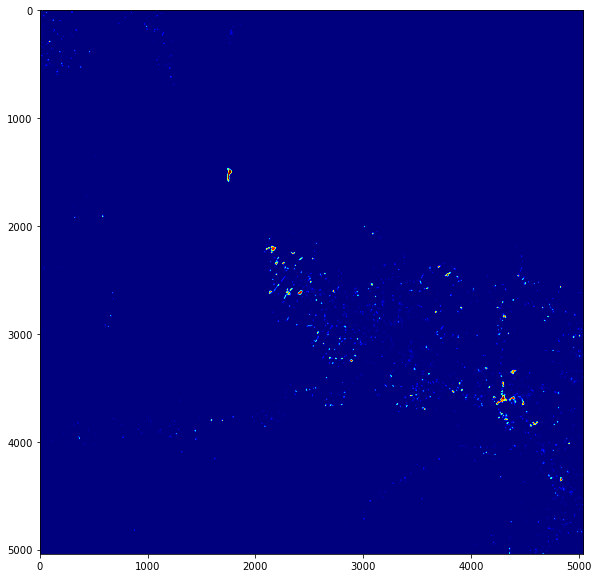

In [12]:
prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)

fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')

In [13]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1

# Number of thresholds to generate the curve    
Npoints = 6
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 69)
np.save(path_exp+'/acc_metrics.npy',metrics_)

0.9933619499206543
0.9591080895785628
0.9248542292364712
0.8906003688943798
0.8563465085522882
0.8220926482101967
0.7878387878681051
0.7535849275260136
0.7193310671839221
0.6850772068418305
0.650823346499739
0.6165694861576475


KeyboardInterrupt: 

Exception ignored in: 'skimage.morphology._max_tree._is_valid_neighbor'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 5, in unravel_index
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Complete NaN values
metrics_copy = metrics_.copy()
metrics_copy = complete_nan_values(metrics_copy)
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]

# Generating mAP curve
mAP = Area_under_the_curve(Recall, Precision)
print('mAP: ', mAP)

plt.close('all')
plt.plot(Recall, Precision)
plt.grid()